In [1]:
import tensorflow as tf
from __future__ import print_function
import numpy as np


/usr/local/Cellar/python3/3.6.4_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## A1 Q1
Euclidean distance function, vectorized    

In [2]:
def euclideanDistance(x, z):
    '''
    We vectorized the operation with matrix operations
    the ||x - z ||^2 is = Sum(x - z)^2 = Sum from 1 to D
    of (x^2 - 2xz + z^2)
    
    x^2 = x^T times x
    z^2 = z^T times z
    we can find the sum of each row by using the reduce sum function
    
    sum of -2xz 
    we can use matrix multiplication, x times z^T to obtain xz,
    then multiply by -2
    '''
    n1 = x.shape[0]
    n2 = z.shape[0]    
    
    x_squared = tf.square(x)
    z_squared = tf.square(z) #tf.matmul(z ,tf.transpose(z))
    #print("x_squared.eval()")
    #print(x_squared.eval())
    x_2_sum = tf.reduce_sum(x_squared, 1)
    z_2_sum = tf.reduce_sum(z_squared, 1)
    
    x_2_sum = tf.transpose(x_2_sum)
    z_2_sum = tf.transpose(z_2_sum)
    #x_2_sum = tf.reshape(x_2_sum, [-1, 1])
    #z_2_sum = tf.reshape(z_2_sum, [-1, 1])
    #print("x_2_sum.eval()")
    #print(x_2_sum.eval())
    
    xz = tf.matmul(x, tf.transpose(z))
    #print(xz.eval())
    minus_2xz = tf.scalar_mul(-2, xz)
    #print(minus_2xz.eval())
 
    x_2_tile =tf.tile(tf.expand_dims(x_2_sum, 1), [1, n2])
    z_2_tile = tf.tile(tf.expand_dims(z_2_sum ,1), [1, n1])
    z_2_tile_T = tf.transpose(z_2_tile)
    #print(x_2_tile.eval())
    #print(z_2_tile_T.eval())
    
    result = x_2_tile + minus_2xz +z_2_tile_T
    
    return result

def squared_dist(A): 
    expanded_a = tf.expand_dims(A, 1)
    expanded_b = tf.expand_dims(A, 0)
    distances = tf.reduce_sum(tf.squared_difference(expanded_a, expanded_b), 2)
    return distances


def testi():
    A = tf.constant([[1, 1], [2,2], [3, 3]])
    B = tf.constant([[1, 1], [2, 2],[3,3]])
    res_mine = euclideanDistance(A, B)
    
    print("----my func----")
    print(res_mine.eval())
    print("---diff square---")
    res_lib = squared_dist(A)
    print(res_lib.eval())
    
with tf.Session() as sess1:
    testi()
    
    


----my func----
[[0 2 8]
 [2 0 2]
 [8 2 0]]
---diff square---
[[0 2 8]
 [2 0 2]
 [8 2 0]]


## A1 Q2
### part 1

| x1^T | x2^T | .... |
top k closest in x1^T indices are the neighbours


yˆ(x∗) = YTr∗, where r∗ = [r1,...,rN],rn = 1/k
0, otherwise.




In [9]:
#given starter code
import numpy as np
import matplotlib.pyplot as plt

# my code part1 responsibility
def nearestIndices(_dist_mat, _k):
    # with tf.Session() as sess:
    #_dist_mat = tf.constant([ [4, 9], [16, 25] ], tf.int32)
    print("dist mat shape", _dist_mat.shape)
    nearest_k = tf.nn.top_k(tf.negative(_dist_mat), _k)
       
    #print(nearest_k.indices.eval())
    indices_arr = nearest_k.indices.eval()
    #print(type(indices_arr))
    return indices_arr

def responsibility(_neighbours, _k, _n ):
    respon = np.zeros(_n) #total number of data
    #find intersection of _data and _neighbours
    #print(type(_neighbours))
    
    one_over_k = 1/_k
    for i in _neighbours: #_neighbours:
        respon[i] +=one_over_k   
    print("respon")
    #print(respon)
    return respon
    
    
    

#unit testing
#dist_mat = tf.constant([ 4, 9, 16, 25 ], tf.int32)
#topk = nearestIndices(dist_mat, 2)
#responsibility(topk, 2, 4)



In [13]:
from scipy import spatial as sp
from sklearn import metrics as skm


np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
         + 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget  = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]


def pairDist(_data, _data1):
    #TODO: what if no library function
    dist = skm.pairwise.euclidean_distances(_data, _data1)
    return dist


    

def knn(_trainData, _trainTarget, _new_data, _k):
    #nearest indices
    dist_mat = pairDist(_trainData, _new_data )
    #responsbility
    
    dist_mat = tf.convert_to_tensor(dist_mat)
    dist_matT = tf.transpose(dist_mat)
    nearest_k = nearestIndices(dist_matT, _k)
    respon_mat = responsibility(nearest_k, _k, _trainData.shape[0])
    
    #maximum responsibility
    train_target_tensor = tf.transpose(tf.convert_to_tensor(_trainTarget))
    #print(foo.shape)
    
    respon_tensor = tf.convert_to_tensor(respon_mat)
    #tf.reshape(bar, [10,1])
    #print(bar.shape)
    
    predict = tf.multiply(train_target_tensor, respon_tensor)
    return predict

    
#pairDist(testData) 
#pred_result = knn(testData, testTarget, _k = 3)

In [16]:
#TODO: MSE LOSS
def mseLoss(mse_mat, _n):
    '''
    assume both dims are N by D
    '''
    mse_sum = tf.reduce_sum(mse_mat)
    loss = mse_sum/(2.0 * _n)
    return loss

slice_data_list = [testData, validData]
slice_target_list = [trainTarget, testTarget, validTarget]
num_neighbour_list = [1, 3, 5, 50]
loss_list = []
with tf.Session() as sess_loss:
    for j in num_neighbour_list:
        _y_hat = knn(trainData,trainTarget, testData,  j)
        _y_hat = tf.transpose(_y_hat)
        _y = testTarget
        mse_mat = euclideanDistance(_y_hat, _y) 
        loss = mseLoss(mse_mat, j)
        loss_list.append(loss.eval())
        print("neighbout = " ,j)
        print(loss.eval())

dist mat shape (10, 80)
respon
neighbout =  1
2247.6576943
dist mat shape (10, 80)
respon
neighbout =  3
680.031992668
dist mat shape (10, 80)
respon
neighbout =  5
401.682774252
dist mat shape (10, 80)
respon
neighbout =  50
37.7053775339


dist mat shape (10, 80)
respon
dist mat shape (10, 80)
respon
test_result.shape (1, 80)
ali_result.shape (1, 80)
plot result
target.shape (10, 1)
pred_result.shape (1, 80)


ValueError: x and y must have same first dimension, but have shapes (10, 1) and (80, 1)

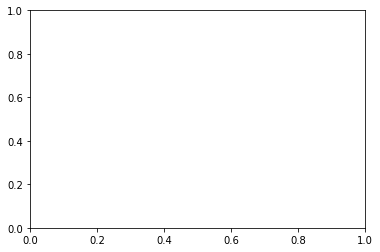

In [24]:
def plotResult(pred_result, target, _num):
    X = np.linspace(0.0, 11.0, num = _num)[:, np.newaxis]

    print("plot result")
    pred_result = pred_result.eval()
    print("target.shape", target.shape)
    print("pred_result.shape", pred_result.shape)
    #target = tf.convert_to_tensor(target)
    pred_result = pred_result.T
    plt.plot(X, pred_result, ".b" )

    plt.plot(X, target, "-r")
    
    plt.show()
    
#training



#print(loss)


with tf.Session() as sess3:
    test_result = knn(trainData, trainTarget, testData, 2)
    vali_result = knn(trainData, trainTarget, validData, 2)
    loss = mseLoss(test_result, testTarget)
    print("test_result.shape", test_result.shape)
    print("ali_result.shape", vali_result.shape)

    plotResult(test_result, testTarget, _num=10)


